# Анализ результатов A/B-тестирования

- Автор: Фёдорова Александра

## Загрузка данных

In [1]:
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import NormalIndPower

In [2]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

## По таблице `ab_test_participants` оценим корректность проведения теста:

    Выделим пользователей, участвующих в тесте, и проверим:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

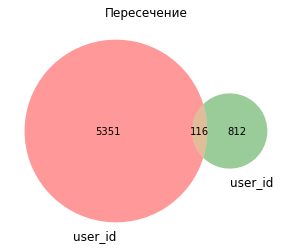

In [3]:
#проверим на пересечения пользователей в группе 'B' в двух тестах
test1_group_b = set(participants[(participants['group'] == 'B') & (participants['ab_test'] == 'interface_eu_test')]['user_id'])
test2_group_b = set(participants[(participants['group'] == 'B') & (participants['ab_test'] == 'recommender_system_test')]['user_id'])

#строим диаграмму Венна
venn2([test1_group_b, test2_group_b], set_labels=('user_id', 'user_id'))
plt.title('Пересечение')
plt.show() 

In [4]:
#найдем пересечения
intersection_users = set(participants[(participants['group'] == 'B') & (participants['ab_test'] == 'interface_eu_test')]['user_id']).intersection(participants[(participants['group'] == 'B') & (participants['ab_test'] == 'recommender_system_test')]['user_id'])
display(f"Общих: {len(intersection_users)}")

#удалим пересечения из датафрейма
participants = participants[~participants['user_id'].isin(intersection_users)]

#проверим результат
display(participants)

'Общих: 116'

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac
...,...,...,...,...
14518,FFE5B14BD55C1C5C,A,interface_eu_test,PC
14519,FFE600EEC4BA7685,B,interface_eu_test,Android
14520,FFE7FC140521F5F6,A,interface_eu_test,PC
14521,FFEFC0E55C1CCD4F,A,interface_eu_test,PC


- Удален 231 дубликат

In [5]:
#выделим нужный тест
interface_eu_test_df = participants[participants['ab_test'] == 'interface_eu_test']
#проверим равномерность респределения пользователей по группам теста
test_groups = (interface_eu_test_df.groupby('group')
               .agg({'user_id': 'nunique'})
               .reset_index())
display(test_groups)

,group,user_id
0,A,5383
1,B,5351


- Пользователи распределены равномерно

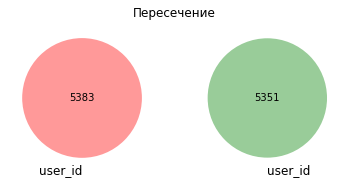

In [6]:
#проверим на пересечения пользователей в двух группах
test_group_a = set(interface_eu_test_df[interface_eu_test_df['group'] == 'A']['user_id'])
test_group_b = set(interface_eu_test_df[interface_eu_test_df['group'] == 'B']['user_id'])

#строим диаграмму Венна
venn2([test_group_a, test_group_b], set_labels=('user_id', 'user_id'))
plt.title('Пересечение')
plt.show() 

- Одинаковых пользователей в двух группах не найдено

##  Проанализируем данные о пользовательской активности по таблице `ab_test_events`:

- оставим только события, связанные с участвующими в изучаемом тесте пользователями;

In [7]:
#присоединим таблицу
merged_df = events.merge(interface_eu_test_df, on='user_id', how='inner')
display(merged_df)

,user_id,event_dt,event_name,details,group,ab_test,device
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,A,interface_eu_test,iPhone
1,5F506CEBEDC05D30,2020-12-07 01:25:14,login,NaN,A,interface_eu_test,iPhone
2,5F506CEBEDC05D30,2020-12-07 01:25:47,login,NaN,A,interface_eu_test,iPhone
3,5F506CEBEDC05D30,2020-12-09 12:40:49,login,NaN,A,interface_eu_test,iPhone
4,5F506CEBEDC05D30,2020-12-09 12:40:49,product_page,NaN,A,interface_eu_test,iPhone
...,...,...,...,...,...,...,...
79061,16CCB1C8C4DCF1AF,2020-12-23 23:50:29,registration,0.0,A,interface_eu_test,Mac
79062,16CCB1C8C4DCF1AF,2020-12-23 23:55:52,login,NaN,A,interface_eu_test,Mac
79063,2DDC948BD76ABC57,2020-12-24 21:57:10,registration,-4.29,B,interface_eu_test,iPhone
79064,2DDC948BD76ABC57,2020-12-24 21:58:49,login,NaN,B,interface_eu_test,iPhone


In [8]:
#удалим дубликаты по событиям
merged_df = merged_df.drop_duplicates(subset=['user_id', 'event_name'])

## Определим горизонт анализа: 
- рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [9]:
#найдем дату регистрации для каждого пользователя
regist_date = merged_df.groupby('user_id')['event_dt'].min().reset_index()
regist_date.columns = ['user_id','regist_date']

#присоединим таблицу
final_df = merged_df.merge(regist_date, on ='user_id')

#настроим фильтр
final_df = final_df[final_df['event_dt'] - final_df['regist_date'] <= pd.Timedelta (days = 7)]

#выведем итоговую таблицу
display(final_df)

,user_id,event_dt,event_name,details,group,ab_test,device,regist_date
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,A,interface_eu_test,iPhone,2020-12-06 14:10:01
1,5F506CEBEDC05D30,2020-12-07 01:25:14,login,NaN,A,interface_eu_test,iPhone,2020-12-06 14:10:01
2,5F506CEBEDC05D30,2020-12-09 12:40:49,product_page,NaN,A,interface_eu_test,iPhone,2020-12-06 14:10:01
3,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,A,interface_eu_test,Android,2020-12-06 14:37:25
4,51278A006E918D97,2020-12-07 01:49:18,login,NaN,A,interface_eu_test,Android,2020-12-06 14:37:25
...,...,...,...,...,...,...,...,...
35773,16CCB1C8C4DCF1AF,2020-12-23 23:50:29,registration,0.0,A,interface_eu_test,Mac,2020-12-23 23:50:29
35774,16CCB1C8C4DCF1AF,2020-12-23 23:55:52,login,NaN,A,interface_eu_test,Mac,2020-12-23 23:50:29
35775,2DDC948BD76ABC57,2020-12-24 21:57:10,registration,-4.29,B,interface_eu_test,iPhone,2020-12-24 21:57:10
35776,2DDC948BD76ABC57,2020-12-24 21:58:49,login,NaN,B,interface_eu_test,iPhone,2020-12-24 21:57:10


Оценим достаточность выборки для получения статистически значимых результатов A/B-теста.

In [10]:
#задаём параметры
alpha = 0.05 
beta = 0.2
power = 0.8 
p = 0.30 
mde = 0.03  
effect_size = proportion_effectsize(p, p + mde)

#инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

#рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3761


- рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [11]:
purchase_users_group_a = final_df[(final_df['event_name'] == 'purchase') & (final_df['group'] == 'A')]['user_id'].nunique()
display(f'Кол-во посетителей сделавших покупку в группе А: {purchase_users_group_a}')

purchase_users_group_b = final_df[(final_df['event_name'] == 'purchase') & (final_df['group'] == 'B')]['user_id'].nunique()
display(f'Кол-во посетителей сделавших покупку в группе B: {purchase_users_group_b}')


'Кол-во посетителей сделавших покупку в группе А: 1480'

'Кол-во посетителей сделавших покупку в группе B: 1579'

In [12]:
users_count_group_a = final_df[final_df['group'] == 'A']['user_id'].nunique()
display(f'Общее кол-во посетителей в группе А: {users_count_group_a}')

users_count_group_b = final_df[final_df['group'] == 'B']['user_id'].nunique()
display(f'Общее кол-во посетителей в группе B: {users_count_group_b}')

'Общее кол-во посетителей в группе А: 5383'

'Общее кол-во посетителей в группе B: 5351'

In [13]:
group_a = round(1480 / 5383 * 100,1)
group_b = round(1579 / 5351 * 100,1)
display(f'Конверсия в группе А составляет: {group_a}%')
display(f'Конверсия в группе В составляет: {group_b}%')
display(f'Прирост составил: {group_b - group_a}%')

'Конверсия в группе А составляет: 27.5%'

'Конверсия в группе В составляет: 29.5%'

'Прирост составил: 2.0%'

- Плановый прирост составляет 3%, поэтому предварительно плановый прирост в тестовой группе оказался меньше

## Проведем оценку результатов A/B-тестирования:

Сформулируем гипотезу
- H₀: новая версия сайта не повлияет на конверсию пользователей (pA=pB)
- H₁: новая версия сайта увеличит конверсию пользователей на 3% (pA<pB)


In [14]:
#проведем z-test пропорций
from statsmodels.stats.proportion import proportions_ztest

n_a, n_b = 5383, 5467 #размер выборок A и B                    
m_a, m_b = 1480, 1600  #конверсия

alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' #так как H_1: p_a < p_в
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.020306993983065475 < 0.05
Нулевая гипотеза не находит подтверждения!


## Вывод 

 Плановый прирост составляет 3%, но фактически получилось 2%. Прирост есть, но не был достигнут ожидаемый эффект.